In [2]:
import os 

import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

import tensorflow as tf
import bayesflow as bf

from skimage.util import random_noise
from tensorflow.keras.utils import to_categorical
from tensorflow_probability import distributions as tfd
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [ ]:
# Comment out, if you want scientific notation
np.set_printoptions(suppress=True)

In [ ]:
# Comment out, if you want tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Set up Forward Inference

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [7]:
forward_train = {
    'prior_draws': train_images,
    'sim_data': train_images
}

num_val = 500
perm = np.random.default_rng(seed=42).permutation(test_images.shape[0])

forward_val = {
    'prior_draws': test_images[perm[:num_val]],
    'sim_data': test_images[perm[:num_val]],
}

forward_test = {
    'prior_draws': test_images[perm[num_val:]],
    'sim_data': test_images[perm[num_val:]],
}

val_labels = test_labels[perm[:num_val]]
test_labels = test_labels[perm[num_val:]]

In [8]:
def grayscale_camera(theta, noise="poisson", psf_width=2.5, noise_scale=1, noise_gain=0.5):
    """Creates a noisy blurred image.
    
    Parameters:
    ----------
    theta       : input image to be blurred.
    noise       : noise type.
    psf_width   : width of point-spread function.
    noise_scale : scale for noise distribution.
    noise_gain  : gain for noise distribution.
    """
    
    image1 = noise_gain * random_noise(noise_scale * theta, mode=noise)
    image2 = gaussian_filter(image1, sigma=psf_width)
    return image2

# Configurator

In [9]:
def configurator(f):
    
    out = {
        'likelihood_inputs': {},
        'posterior_inputs': {}
    }
    
    B = f['prior_draws'].shape[0]
    H = f['prior_draws'].shape[1]
    W = f['prior_draws'].shape[2]
    
    # Normalize image between -1 and 1
    p = (f['prior_draws']).reshape((B, H*W)).astype(np.float32)
    p = -1. + (p * 2) / 255. 
    
    # Add blurr
    blurred = np.stack([grayscale_camera(f['sim_data'][b]) for b in range(B)]).astype(np.float32)
    
    # Add likelihood inputs + some dequantization noise
    out['likelihood_inputs']['summary_conditions'] = p.reshape((B, W, H, 1))
    out['likelihood_inputs']['parameters'] = blurred.reshape((B, H*W)) + 1e-3 * np.random.normal(size=(B, W*H)) 
    
    # Add posterior inputs + some dequantization noise
    out['posterior_inputs']['parameters'] = p + 1e-3 * np.random.normal(size=p.shape)
    out['posterior_inputs']['summary_conditions'] = blurred[..., None]
    return out

# Sanity Check

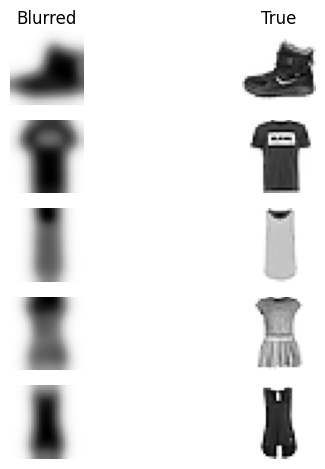

In [10]:
how_many = 5
conf = configurator({
    'sim_data': forward_train['sim_data'][:how_many],
    'prior_draws': forward_train['prior_draws'][:how_many],
})

f, axarr = plt.subplots(how_many, 2)
for i in range(how_many):
    if i == 0:
        axarr[i, 0].set_title('Blurred')
        axarr[i, 1].set_title('True')
    axarr[i, 0].imshow(conf['posterior_inputs']['summary_conditions'][i, :, :, 0], cmap=plt.cm.get_cmap('Greys'))
    axarr[i, 1].imshow(forward_train['prior_draws'][i].reshape(28, 28), cmap=plt.cm.get_cmap('Greys'))
    axarr[i, 0].axis('off')
    axarr[i, 1].axis('off')
f.tight_layout()

# Set up Amortizers

## Convolutional Summary Networks

In [11]:
summary_network_l = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        input_shape=(28, 28, 1), 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=128, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=128, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D()
])

2023-06-09 11:48:10.759290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 11:48:10.777119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 11:48:10.778822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 11:48:10.781095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [12]:
summary_network_p = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        input_shape=(28, 28, 1), 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=128, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=128, 
        kernel_size=(3, 3), 
        activation='relu', 
        kernel_initializer='he_normal', 
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D()
])

## Affine Coupling Approximators

In [13]:
coupling_settings = {
    "dense_args": dict(units=512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    "num_dense": 1,
    "dropout_prob": 0.15
}

posterior_net = bf.networks.InvertibleNetwork(
    num_params=int(28*28),
    num_coupling_layers=12,
    coupling_settings=coupling_settings
)

likelihood_net = bf.networks.InvertibleNetwork(
    num_params=int(28*28),
    num_coupling_layers=12,
    coupling_settings=coupling_settings
)

dim = int(28*28)
loc = [0.]*dim
scale = tf.linalg.LinearOperatorDiag([1.]*dim)
latent_dist = tfd.MultivariateStudentTLinearOperator(df=100, loc=loc, scale=scale)

amortized_posterior = bf.amortizers.AmortizedPosterior(
    posterior_net, summary_net=summary_network_p, latent_dist=latent_dist, summary_loss_fun='MMD')
amortized_likelihood = bf.amortizers.AmortizedPosterior(
    likelihood_net, summary_net=summary_network_l, latent_dist=latent_dist)
amortizer = bf.amortizers.AmortizedPosteriorLikelihood(amortized_posterior, amortized_likelihood)

# Trainer definition

In [65]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    checkpoint_path='checkpoints/joint',
    configurator=configurator,
    default_lr=1e-3,
    memory=False,
    max_to_keep=1
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from checkpoint/joint/history_120.pkl.
INFO:root:Networks loaded from checkpoint/joint/ckpt-120


## Offline Training
Uncomment for training.

In [66]:
# %%time
# h = trainer.train_offline(forward_train, epochs=120, batch_size=32, validation_sims=forward_val)

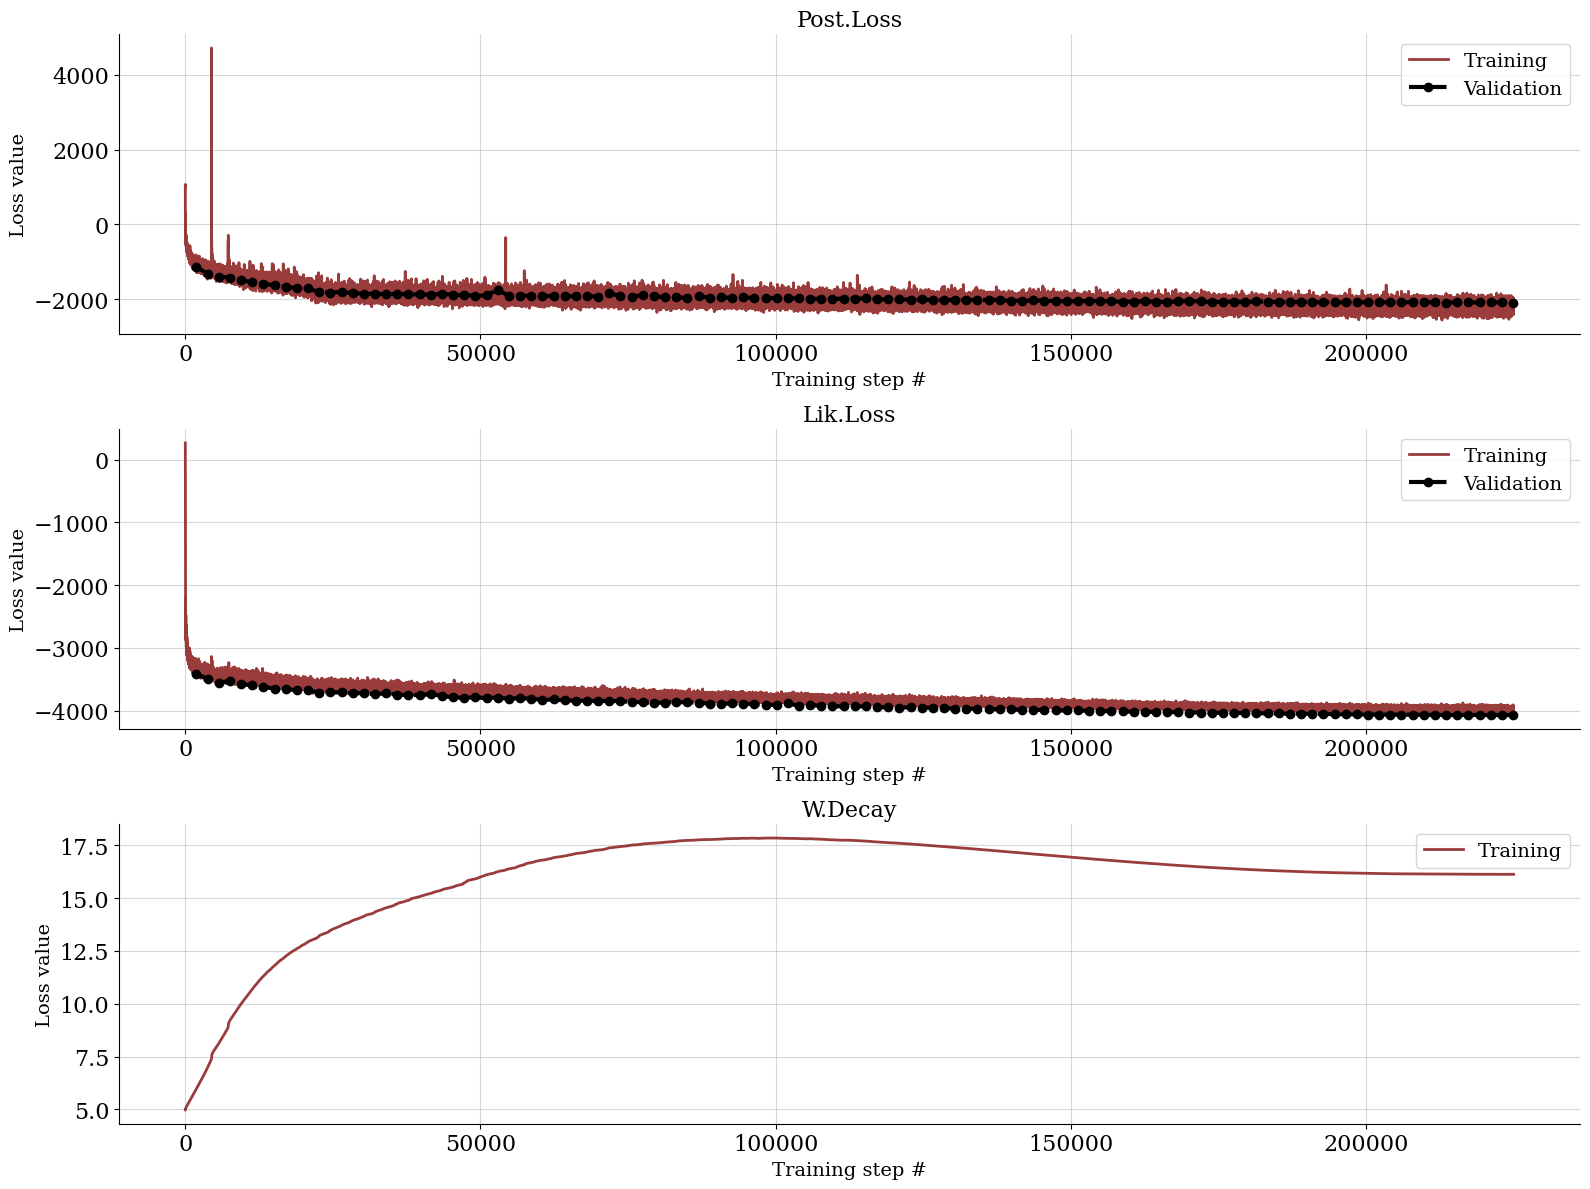

In [67]:
h = trainer.loss_history.get_plottable()
f = bf.diagnostics.plot_losses(h['train_losses'], h['val_losses'])

In [68]:
f.savefig('figures/loss_history.pdf', bbox_inches='tight', dpi=300)

# Validation

In [17]:
plt.rcParams.update({
    "axes.labelsize" : 24,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "legend.fontsize": 24,
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

In [18]:
conf = configurator(forward_test)

## Per-Class Generation: Means and STDs

In [62]:
class_names = [
    'T-Shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
]

y_labels = [r'Parameter $\theta$', r'Observation $x$', 'Mean', 'Std.Dev']

In [110]:
def random_indices_per_class(labels, seed=42):
    out = {}
    unique = np.unique(labels)
    perm = np.random.default_rng(seed).permutation(labels.shape[0])
    for i in unique:
        for idx in perm:
            if i == labels[idx]:
                out[i] = idx
                break
    return out


def create_mean_std_plots(seed=42, filename=None, n_samples=500):
    """Helper function for displaying Figure 7 in main paper.
    Default seed is the one and only 42!
    """
    
    idx_dict = random_indices_per_class(test_labels, seed=seed)
    f, axarr = plt.subplots(4, len(idx_dict), figsize=(12, 4))
    for i, (c, idx) in enumerate(idx_dict.items()):

        # Prepare input dict for network
        inp = {
            'parameters': conf['posterior_inputs']['parameters'][idx:(idx+1)],
            'summary_conditions': conf['posterior_inputs']['summary_conditions'][idx:(idx+1)],
        }

        # Obtain samples and clip to prior range, instead of rejecting
        samples = amortized_posterior.sample(inp, n_samples)
        samples = np.clip(samples, a_min=-1.01, a_max=1.01)

        # Plot truth and blurred
        axarr[0, i].imshow(inp['parameters'].reshape((28, 28, 1)), cmap=plt.cm.get_cmap('binary'))
        axarr[1, i].imshow(inp['summary_conditions'].reshape((28, 28, 1)), cmap=plt.cm.get_cmap('binary'))
        axarr[2, i].imshow(samples.mean(0).reshape(28, 28, 1), cmap=plt.cm.get_cmap('binary'))
        axarr[3, i].imshow(samples.std(0).reshape(28, 28, 1), cmap=plt.cm.get_cmap('binary'))

        axarr[0, i].set_title(class_names[i])

    for j, label in enumerate(y_labels):   
        axarr[j, 0].set_ylabel(label, rotation=0, labelpad=55, fontsize=12)

    # get rid of axis
    for ax in axarr.flat:
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_xticks([])
    f.tight_layout()
    
    if filename is not None:
        f.savefig(f'figures/{filename}.pdf', dpi=300, bbox_inches='tight')
    return f

def create_likelihood_samples_plot(seed=42, n_samples=10, figsize=(18, 10), filename=None):
    idx_dict = random_indices_per_class(test_labels, seed=seed)
    f, axarr = plt.subplots(len(idx_dict), n_samples+2, figsize=figsize)
    for i, (c, idx) in enumerate(idx_dict.items()):

        # Prepare input dict for network
        inp = {
            'summary_conditions': conf['likelihood_inputs']['summary_conditions'][idx:(idx+1)],
            'parameters': conf['likelihood_inputs']['parameters'][idx:(idx+1)]
        }

        # Obtain samples
        samples = amortized_likelihood.sample(inp, n_samples)

        # Plot truth and blurred
        axarr[i, 0].imshow(inp['summary_conditions'].reshape((28, 28, 1)), cmap=plt.cm.get_cmap('binary'))
        axarr[i, 1].imshow(inp['parameters'].reshape((28, 28, 1)), cmap=plt.cm.get_cmap('binary'))

        # Plot samples
        for j in range(n_samples):
            axarr[i, j+2].imshow(samples[j].reshape((28, 28, 1)), cmap=plt.cm.get_cmap('binary'))

        # get rid of axis
        for ax in axarr[i, :]:
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_yticklabels([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_xticks([])

        if i == 0:
            axarr[i, 0].set_title(r'Ground truth $\theta^*$')
            axarr[i, 1].set_title(r'Data $x$')
            for j in range(n_samples):
                axarr[i, j+2].set_title(f'Sample #{j+1}')
        axarr[i, 0].set_ylabel(class_names[i], rotation=0, labelpad=40, fontsize=14)
    f.tight_layout()

    if filename is not None:
        f.savefig(f'figures/{filename}.pdf', dpi=300, bbox_inches='tight')
    return f

### Main Paper

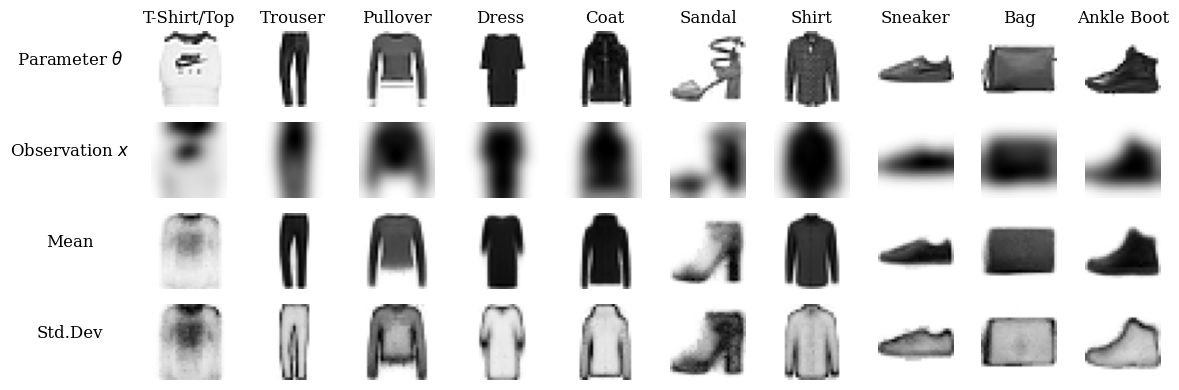

In [85]:
f = create_mean_std_plots(seed=42, filename='main')

## Appendix

### Posterior

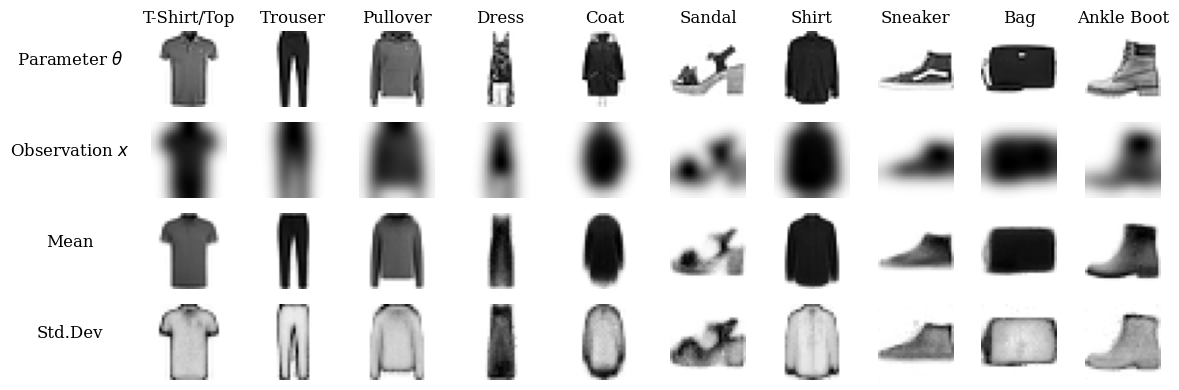

In [87]:
f = create_mean_std_plots(seed=43, filename='appendix_1')

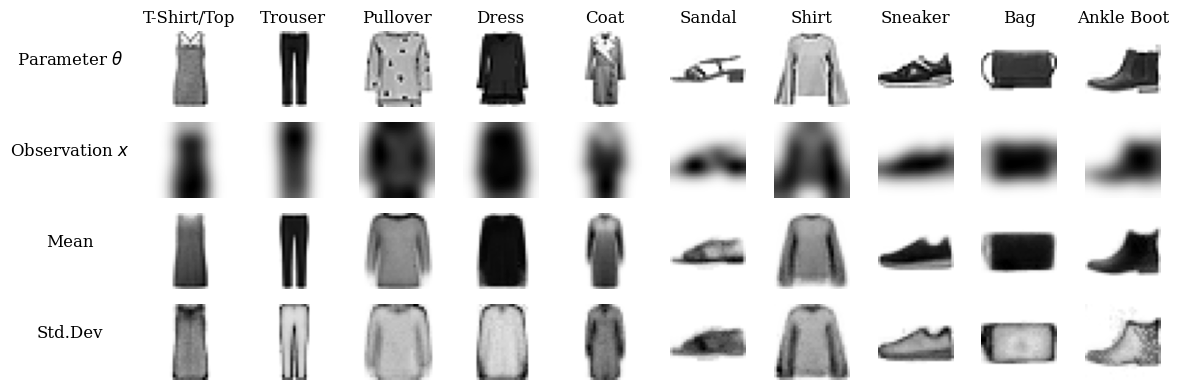

In [88]:
f = create_mean_std_plots(seed=44, filename='appendix_2')

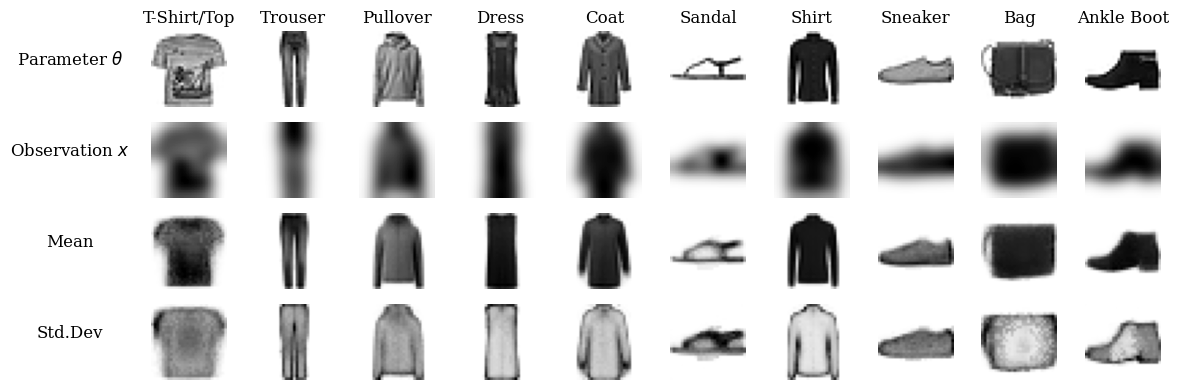

In [89]:
f = create_mean_std_plots(seed=45, filename='appendix_3')

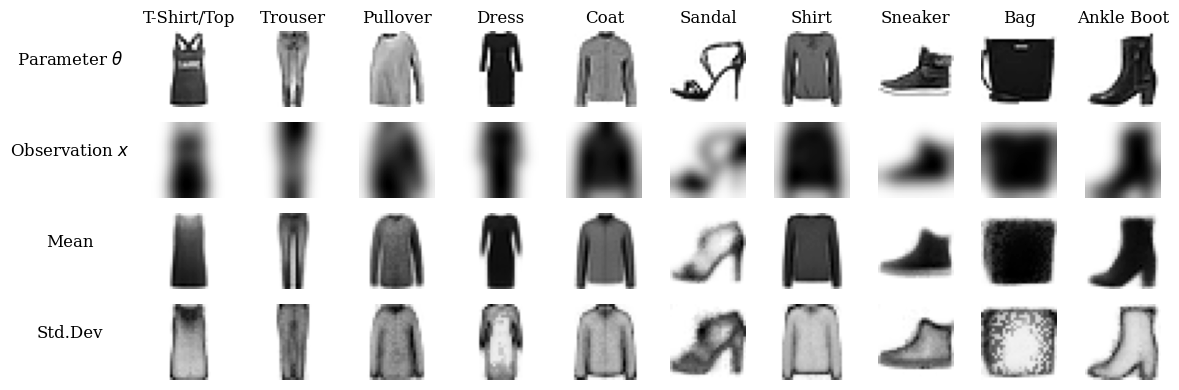

In [90]:
f = create_mean_std_plots(seed=46, filename='appendix_4')

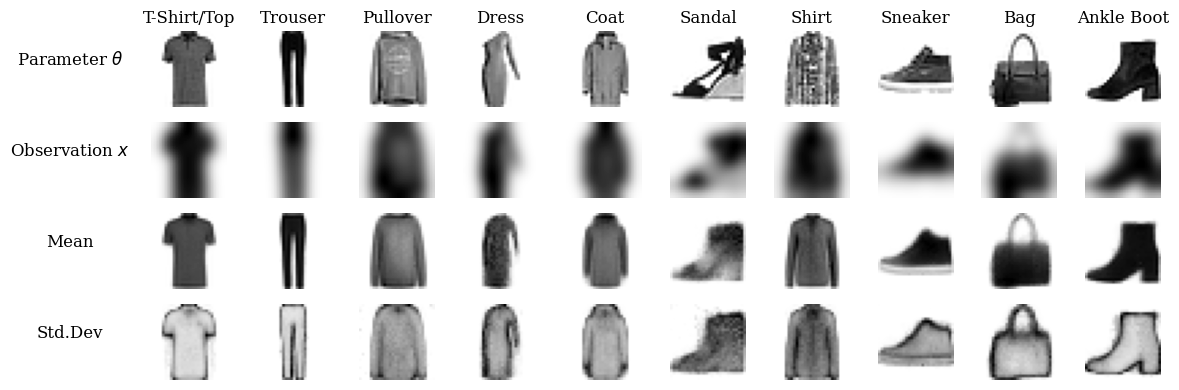

In [91]:
f = create_mean_std_plots(seed=47, filename='appendix_5')

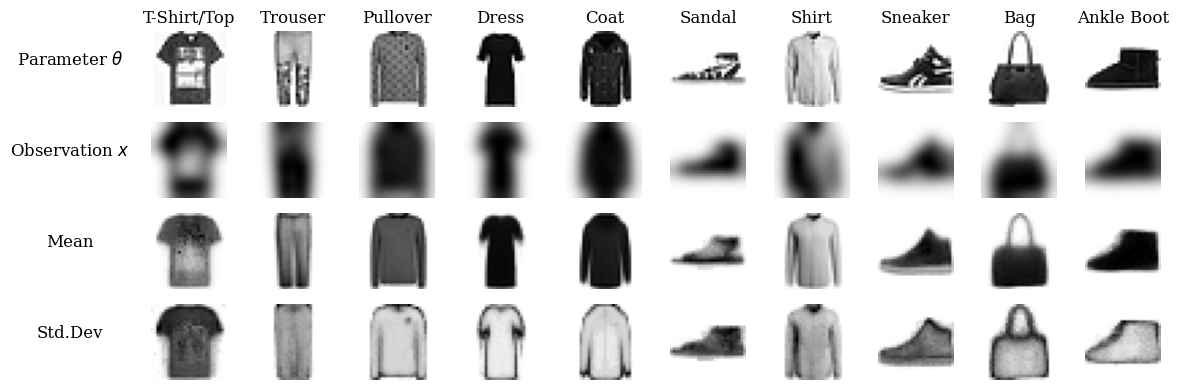

In [97]:
f = create_mean_std_plots(seed=48, filename='appendix_6')

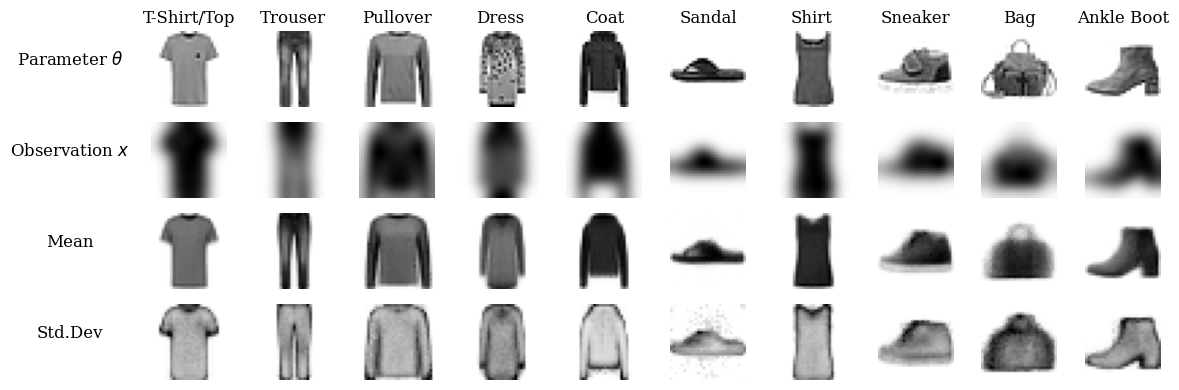

In [98]:
f = create_mean_std_plots(seed=49, filename='appendix_7')

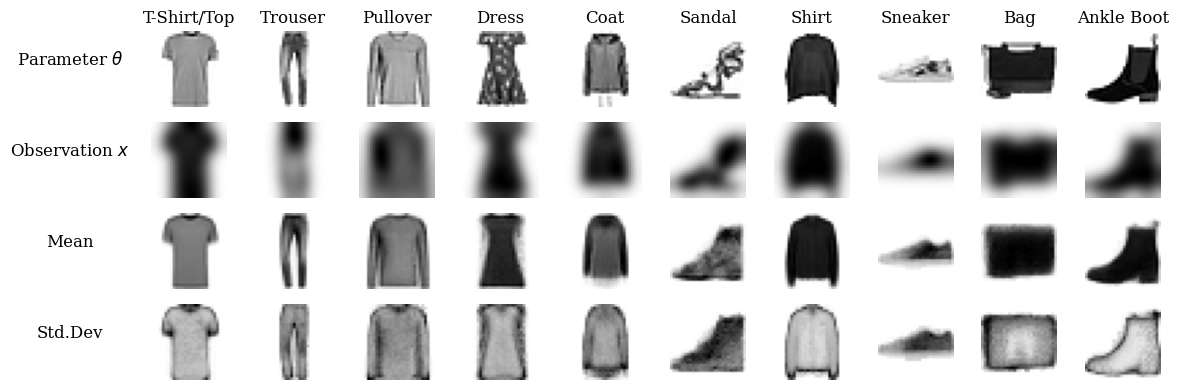

In [99]:
f = create_mean_std_plots(seed=50, filename='appendix_8')

### Likelihood

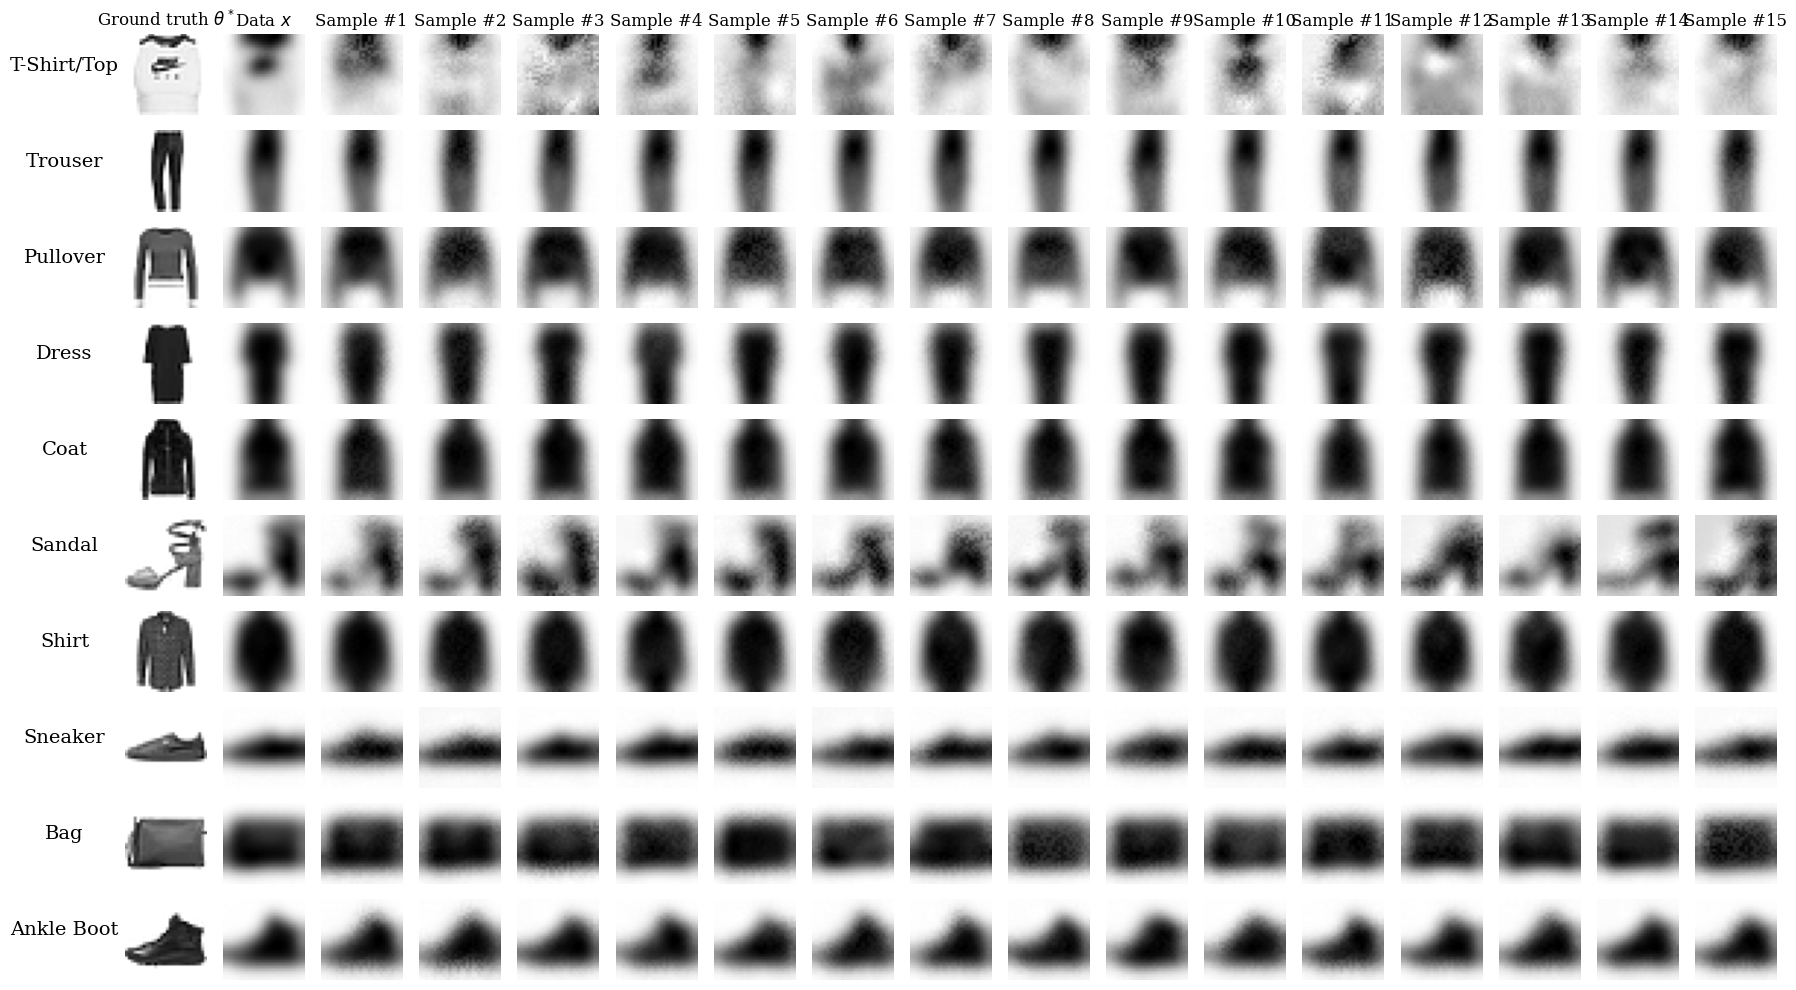

In [111]:
f = create_likelihood_samples_plot(seed=42, n_samples=15, filename='likelihood_samples1')

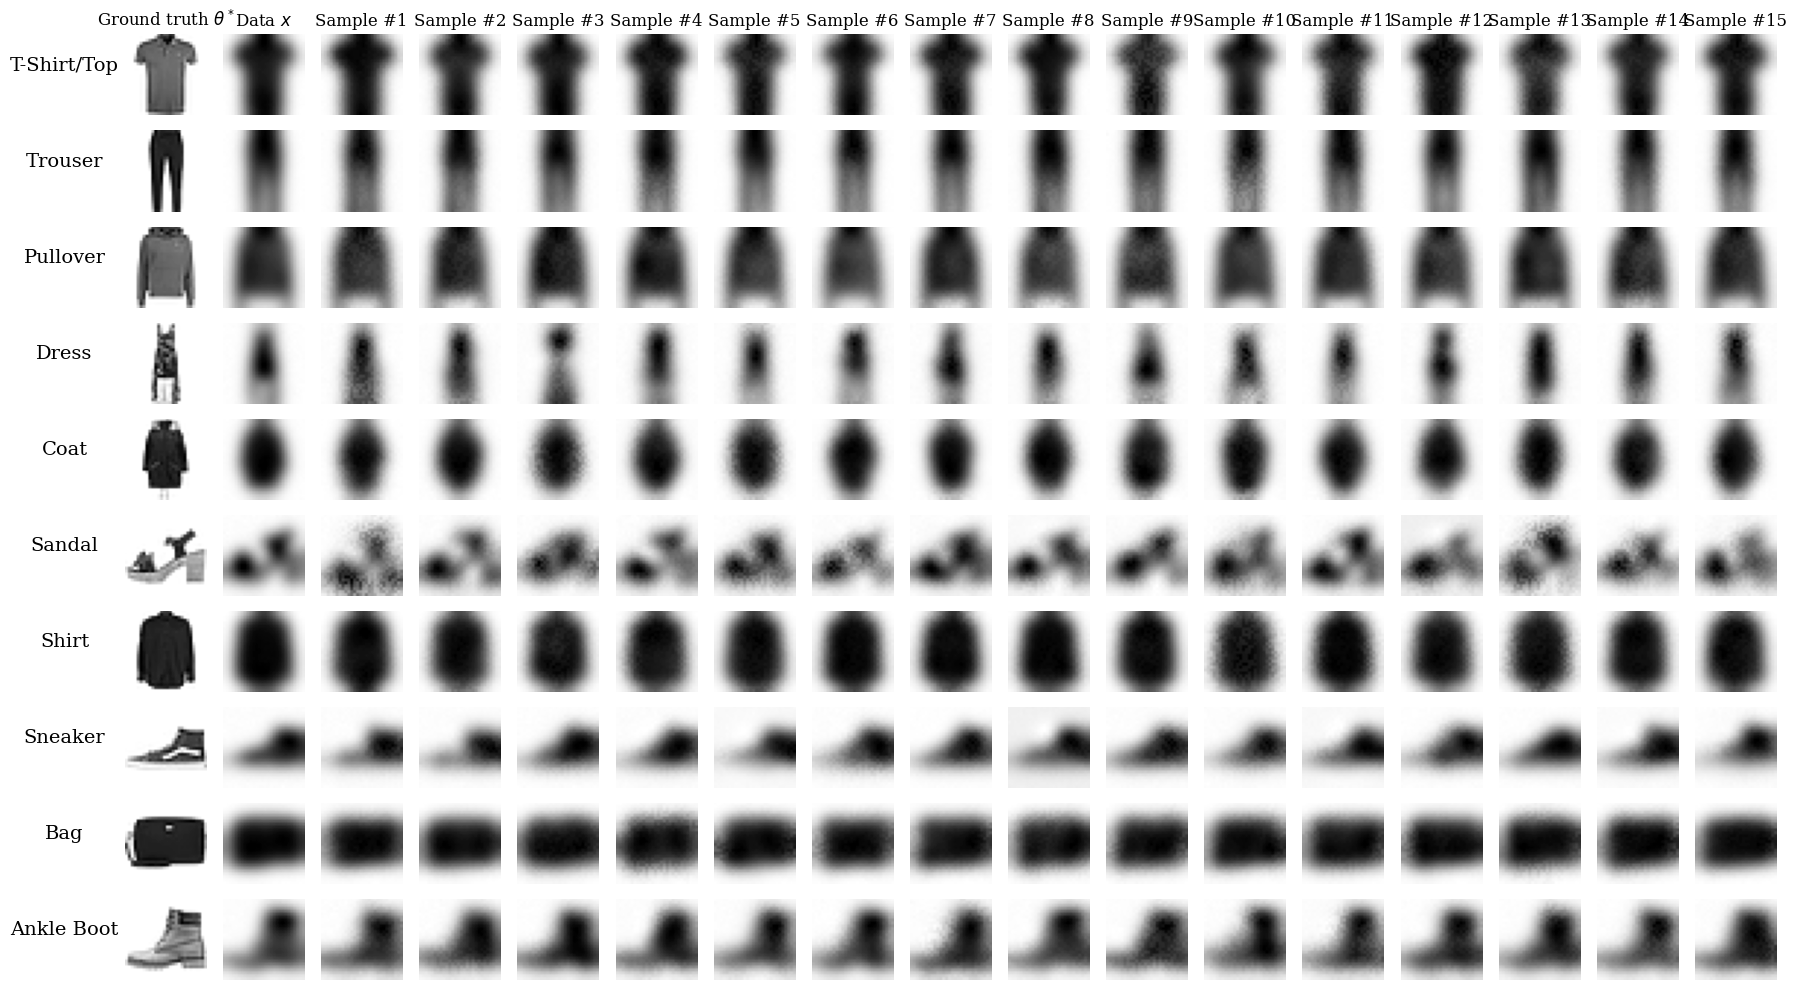

In [112]:
f = create_likelihood_samples_plot(seed=43, n_samples=15, filename='likelihood_samples2')

## Calibration

### Posterior

In [49]:
# # Free up some memory at this point in the script
del trainer
del h
del train_images
del test_images
del forward_train

In [26]:
# Prepare input conditions for posterior network
posterior_conds = tf.split(conf['posterior_inputs']['summary_conditions'], 100)
posterior_inputs = [{'summary_conditions': c} for c in posterior_conds]

# Generate posterior samples given camera and surroaget camera
post_samples = amortized_posterior.sample_loop(posterior_inputs, n_samples=100)

In [36]:
parameters = conf['posterior_inputs']['parameters']

#### Numerical summary
Note: This may take up to 10 minutes!

In [30]:
cal_errs_post = bf.computational_utilities.posterior_calibration_error(post_samples, parameters)

Text(0.5, 0, 'Median Calibration Error')

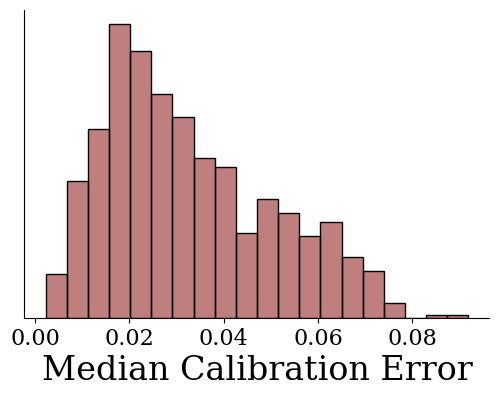

In [31]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(cal_errs_post, bins=20, color='maroon', alpha=0.5, ax=ax)
sns.despine(ax=ax)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xlabel('Median Calibration Error')

In [33]:
print('Mean calibration error: ', np.mean(cal_errs_post))
print('SD of calibration error: ', np.std(cal_errs_post))

Mean calibration error:  0.03268703007518796
SD of calibration error:  0.017665297502327083


#### Visual
Randomly pick 64 pixels, otherwise messy.

In [37]:
# Extract 1000 random test images
to_plot_datasets = np.random.default_rng(42).permutation(parameters.shape[0])[:1000]
to_plot_pixels = np.random.default_rng(42).permutation(parameters.shape[1])[:64]
post_samples_plot = post_samples[to_plot_datasets]
ground_truths_plot = parameters[to_plot_datasets]
post_samples_plot = post_samples_plot[:, :, to_plot_pixels]
ground_truths_plot = ground_truths_plot[:, to_plot_pixels]

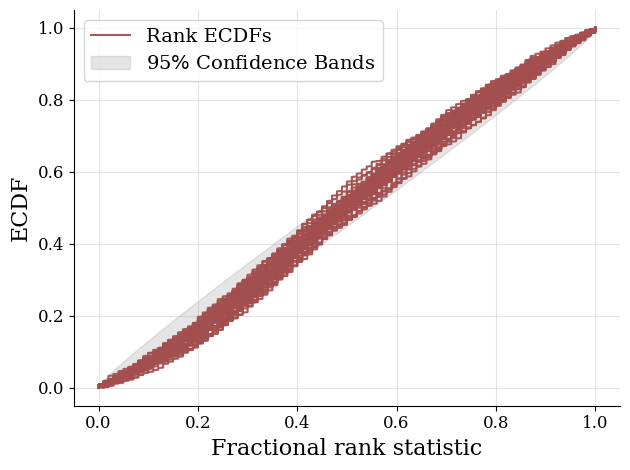

In [38]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_plot, ground_truths_plot, stacked=True)

### Likelihood + Posterior

In [50]:
del post_samples

In [51]:
# Prepare input dictionary for likelihood network
likelihood_conds = tf.split(conf['likelihood_inputs']['summary_conditions'], 100)
likelihood_inputs = [{'summary_conditions': c} for c in likelihood_conds]

# Generate synthetic blurrs for likelihood network
synthetic_blur = np.squeeze(amortized_likelihood.sample_loop(likelihood_inputs, 1))
synthetic_blur = np.reshape(synthetic_blur, (synthetic_blur.shape[0], 28, 28, 1))
posterior_synth_conds = tf.split(synthetic_blur, 100)
posterior_synth_inputs = [{'summary_conditions': c} for c in posterior_synth_conds]
post_samples_synth = amortized_posterior.sample_loop(posterior_synth_inputs, n_samples=100)

#### Numerical summary
Note: This may take up to 10 minutes! Summarizes total calibration using four numbers.

In [52]:
cal_errs_joint = bf.computational_utilities.posterior_calibration_error(post_samples_synth, parameters)

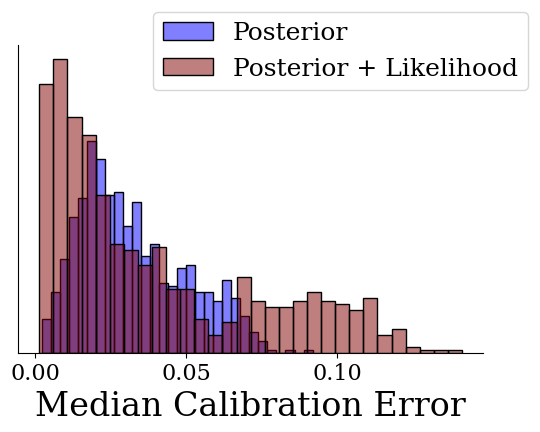

In [94]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(cal_errs_post, bins=30, color='blue', alpha=0.5, ax=ax, label='Posterior')
sns.histplot(cal_errs_joint, bins=30, color='maroon', alpha=0.5, ax=ax, label='Posterior + Likelihood')
sns.despine(ax=ax)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xlabel('Median Calibration Error')
f.legend(fontsize=18)

In [95]:
print('Mean calibration error: ', np.mean(cal_errs_joint))
print('SD of calibration error: ', np.std(cal_errs_joint))

Mean calibration error:  0.039109291084854995
SD of calibration error:  0.03426084848284964


In [96]:
f.savefig('figures/calibration_error.pdf', dpi=300, bbox_inches='tight')